In [138]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split


# data = yf.download('BTC-USD', start='2019-06-01', end='2019-06-07')
data = yf.download('BTC-USD', start='2019-06-01', end='2024-06-02')
data.reset_index(inplace=True)
data.index = data.index + 1
data['Date'] = data['Date'].dt.date

# data

[*********************100%%**********************]  1 of 1 completed


In [139]:
x = data[['Open','High','Low','Close']]
y = data[['Close']]

x, y

(              Open          High           Low         Close
 1      8573.839844   8625.600586   8481.578125   8564.016602
 2      8565.473633   8809.303711   8561.235352   8742.958008
 3      8741.747070   8743.500000   8204.185547   8208.995117
 4      8210.985352   8210.985352   7564.488770   7707.770996
 5      7704.343262   7901.849121   7668.668457   7824.231445
 ...            ...           ...           ...           ...
 1824  69392.195312  69514.640625  67227.156250  68296.218750
 1825  68296.351562  68852.460938  67101.492188  67578.093750
 1826  67576.085938  69500.539062  67118.078125  68364.992188
 1827  68362.515625  68999.562500  66633.421875  67491.414062
 1828  67489.609375  67839.765625  67386.195312  67706.937500
 
 [1828 rows x 4 columns],
              Close
 1      8564.016602
 2      8742.958008
 3      8208.995117
 4      7707.770996
 5      7824.231445
 ...            ...
 1824  68296.218750
 1825  67578.093750
 1826  68364.992188
 1827  67491.414062
 1828  6

In [140]:
min_x = x.min()
max_x = x.max()
x_scaled = (x - min_x) / (max_x - min_x)

# x_scaled

In [141]:
min_y = y.min()
max_y = y.max()
y_scaled = (y - min_y) / (max_y - min_y)

# y_scaled

In [142]:
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y_scaled, test_size=0.2, shuffle=False)

# X_train, X_test, y_train, y_test

In [143]:
class SVR_Model:
    def __init__(self, gamma, C, epsilon, max_iter=1000):
        self.gamma = gamma
        self.C = C
        self.epsilon = epsilon
        self.alpha = None
        self.alpha_star = None
        self.X_train = None
        self.max_iter = max_iter

    def rbf_kernel(self, X, X2):
        """Calculate the RBF kernel between two datasets."""
        X = np.asarray(X)
        X2 = np.asarray(X2)
        sq_dists = np.sum((X[:, np.newaxis, :] - X2[np.newaxis, :, :])**2, axis=2)
        return np.exp(-self.gamma * sq_dists)

    def train(self, X_train, y_train):
        self.X_train = X_train
        n_samples = X_train.shape[0]
        y_train = np.array(y_train).flatten()
        self.alpha = np.zeros(n_samples)
        self.alpha_star = np.zeros(n_samples)
        K = self.rbf_kernel(X_train, X_train)

        for iteration in range(self.max_iter):
            alpha_prev = np.copy(self.alpha)
            alpha_star_prev = np.copy(self.alpha_star)
            
            for i in range(n_samples):
                Ei = y_train[i] - np.dot((self.alpha - self.alpha_star), K[i])
                delta_alpha = min(max(self.gamma * (Ei - self.epsilon), -self.alpha[i]), self.C - self.alpha[i])  # Perbaikan: Pembaruan delta_alpha dengan batasan yang tepat
                delta_alpha_star = min(max(self.gamma * (-Ei - self.epsilon), -self.alpha_star[i]), self.C - self.alpha_star[i])  # Perbaikan: Pembaruan delta_alpha_star dengan batasan yang tepat
               
                self.alpha[i] += delta_alpha
                self.alpha_star[i] += delta_alpha_star

            # Cek Konvergensi
            norm_alpha_diff = np.linalg.norm(self.alpha - alpha_prev)
            norm_alpha_star_diff = np.linalg.norm(self.alpha_star - alpha_star_prev)
            if norm_alpha_diff < self.epsilon and norm_alpha_star_diff < self.epsilon:
                print(f"Converged after {iteration} iterations.")
                break

    def predict(self, X_test):
        """Predict using the trained SVR model."""
        if self.alpha is None or self.alpha_star is None:
            raise Exception("Model has not been trained yet.")
        K_test = self.rbf_kernel(X_test, self.X_train)
        alpha_coef = self.alpha - self.alpha_star
        return np.dot(K_test, alpha_coef)

    def predict_future(self, current_features):
        """Predict using the trained SVR model."""
        if self.alpha is None or self.alpha_star is None:
            raise Exception("Model has not been trained yet.")
        K_future = self.rbf_kernel(current_features, self.X_train)
        alpha_coef = self.alpha - self.alpha_star
        return np.dot(K_future, alpha_coef)

In [144]:
model = SVR_Model(gamma=1, C=10, epsilon=0.01)
model.train(X_train, y_train)
predictions = model.predict(X_test)

Converged after 266 iterations.


In [145]:
current_features = y_scaled[-4:].values.reshape(1,-1) #Mengambil nilai Close 4 hari terakhir untuk menjadi fitur
future_predictions = []

for i in range(7):
    next_day_pred = model.predict_future(current_features) # Prediksi 1 hari ke depan
    future_predictions.append(next_day_pred) # Simpan hasil prediksi ke future_predictions
    current_features = np.roll(current_features, -1) 
    current_features[0, -1] = next_day_pred[0]

# Prepare data for dynamic prediction
data['Date'] = pd.to_datetime(data['Date'])
data['Date'] = data['Date'].dt.date
last_date = data['Date'].iloc[-1]
future_dates = [last_date + timedelta(days=i) for i in range(1, 8)]

if future_predictions[-1] > future_predictions[0]:
    price_movement = "Rise :arrow_upper_right:"
elif future_predictions[-1] < future_predictions[0]:
    price_movement = "Drop :arrow_lower_right:"

In [146]:
predictions = np.array(predictions).flatten() 
y_test = np.array(y_test).flatten()
future_predictions = np.array(future_predictions).flatten()

min_y = float(min_y.iloc[0])
max_y = float(max_y.iloc[0])

predictions = predictions * (max_y - min_y) + min_y
y_test = y_test * (max_y - min_y) + min_y
future_predictions = future_predictions * (max_y - min_y) + min_y

In [147]:
mape = np.mean(np.abs((y_test - predictions) / y_test)) * 100
accuracy = (100 - mape)

print(f"MAPE: {mape}")
print("Accuracy: {:.2f}%".format(accuracy))

MAPE: 0.6947893401768748
Accuracy: 99.31%


In [148]:
start_index_for_dates = len(data) - len(y_test)
test_dates = data['Date'][start_index_for_dates:].reset_index(drop=True)
comparison_df = pd.DataFrame({
    'Date': test_dates, 
    'Actual': y_test, 
    'Predicted': predictions})
print(comparison_df)

           Date        Actual     Predicted
0    2023-06-02  27249.589844  27135.398746
1    2023-06-03  27075.128906  27050.621278
2    2023-06-04  27119.066406  27116.858389
3    2023-06-05  25760.097656  25910.413536
4    2023-06-06  27238.783203  27017.748231
..          ...           ...           ...
361  2024-05-28  68296.218750  66667.039838
362  2024-05-29  67578.093750  66390.373271
363  2024-05-30  68364.992188  67103.930314
364  2024-05-31  67491.414062  66340.582595
365  2024-06-01  67706.937500  66457.154878

[366 rows x 3 columns]


In [149]:
future_data = pd.DataFrame({
    'Date': future_dates, 
    'Predicted Close': future_predictions})
print(future_data)

         Date  Predicted Close
0  2024-06-02     66616.209338
1  2024-06-03     65639.947009
2  2024-06-04     65208.309787
3  2024-06-05     64618.996606
4  2024-06-06     64240.234875
5  2024-06-07     64052.709075
6  2024-06-08     63851.277862


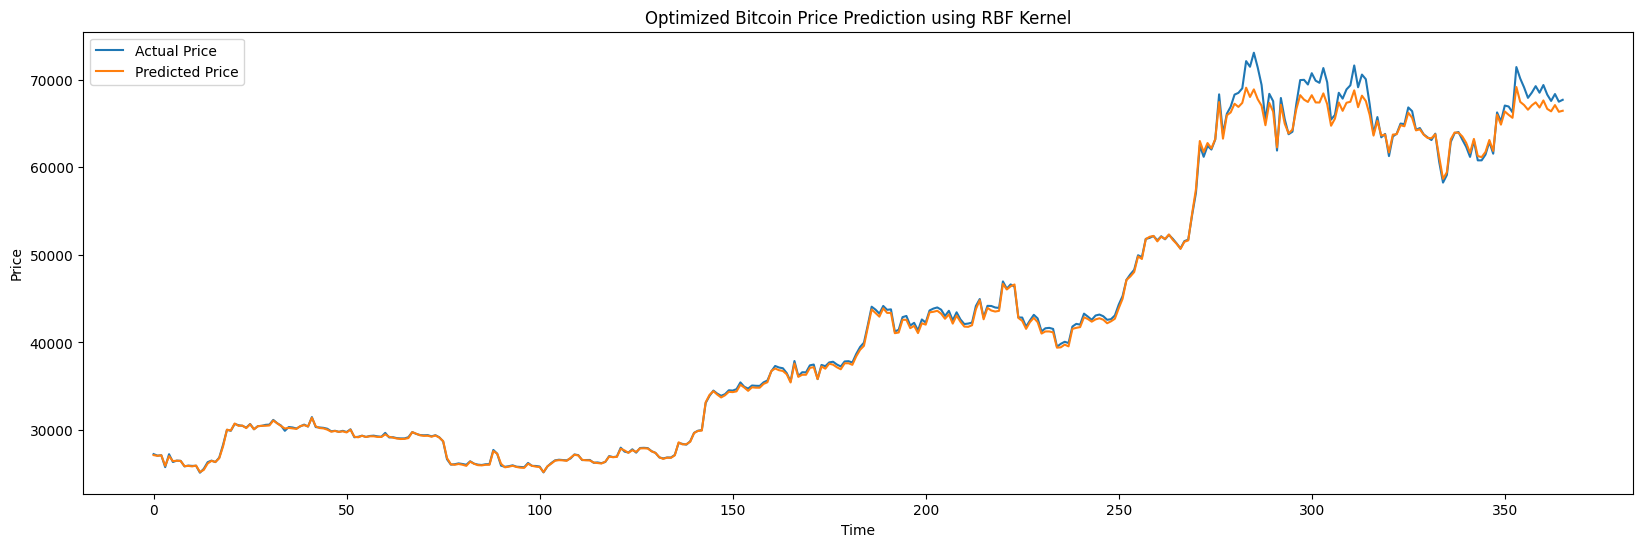

In [150]:
plt.figure(figsize=(20, 6))
plt.plot(y_test, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Optimized Bitcoin Price Prediction using RBF Kernel')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()